In [1]:
from lsst.ts.phosim.CloseLoopTask import CloseLoopTask
from lsst.afw.cameraGeom import PIXELS, FIELD_ANGLE, FOCAL_PLANE
from lsst.geom import Point2D
from astropy.table import Table
from lsst.ts.phosim.utils.Utility import getCamera
import matplotlib.pyplot as plt
import numpy as np

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [7]:
def make_star_per_sensor_inst_catalog(instName = "lsstfam",  xcen = 2000, ycen = 2000,mag = 15,
                                      outDir='/sdf/data/rubin/u/scichris/WORK/AOS/DM-39956/',
                                      fname = ''):
    camera = getCamera(instName)

    # only for instName = "lsst"   
    fieldX, fieldY = list(), list()
    fieldXrad, fieldYrad = list(), list()
    detName = list()

    task = CloseLoopTask()

    for name in task.getSensorNameListOfFields(instName):
        detector = camera.get(name)

        # add grid of points
        xs,ys = np.array([xcen]), np.array([ycen])
        transform = detector.getTransform(PIXELS, FIELD_ANGLE)

        # make a list of points in pixels 
        fps = [Point2D(fpx,fpy) for fpx, fpy in zip(xs,ys)]

        # transform from pixels to radians 
        pixels = transform.applyForward(fps)

        # this is now in field angle coords, i.e. radians
        fpxRad = [pixel.x for pixel in pixels]
        fpyRad = [pixel.y for pixel in pixels]

        # radians to degrees + transpose for phoSim 
        fpyDeg = [np.rad2deg(fp) for fp in fpxRad]
        fpxDeg = [np.rad2deg(fp) for fp in fpyRad]

        fieldXrad = np.append(fieldXrad, fpxRad)
        fieldYrad = np.append(fieldYrad, fpyRad)
        fieldX = np.append(fieldX, fpxDeg)
        fieldY = np.append(fieldY, fpyDeg)
        names = [name for i in range(len(fpxDeg))]
        detName = np.append(detName, names)

    # this is enough information:  fieldX, fieldY in degrees
    # to save the star catalog file 

    # Save the input catalog 

    # make an inst catalog 
    coords = Table(data=[fieldX, fieldY],  names=['Ra','Decl'])

    # add a column with object id 
    ID = np.arange(len(coords))
    coords['Id'] = ID

    coords['Mag'] = mag
    if len(fname) < 1:
        fname = f'{instName}_star_per_sensor_{mag}.txt'
        
    if not os.path.exists(outDir):
        os.makedirs(outDir)  
    fpath = os.path.join(outDir, fname )
    coords[['Id','Ra','Decl','Mag']].write(fpath, 
                                           format='ascii.commented_header',
                                          overwrite=True)
    print(f'saved as {fpath}')
    
    return coords

In [29]:
def apply_rotation(coords):
    # just x,y : this is from 
    # https://github.com/lsst-ts/ts_externalscripts/blob/develop/python/lsst/ts/externalscripts/auxtel/latiss_base_align.py 
    # (((c, -s), 
    #   (s,  c))) 
    matrix_rotation = lambda angle: np.array(
            [
                [np.cos(np.radians(angle)), -np.sin(np.radians(angle))],
                [np.sin(np.radians(angle)), np.cos(np.radians(angle))],
            ])

    angle=30
    xrot=[]
    yrot=[]
    for coord in coords:
        x = coord['Ra']
        y = coord['Decl']
        xy = [x,y]
        xyrot = np.matmul(xy, matrix_rotation(angle))
        #print(xy,xyrot)
        xrot.append(xyrot[0])
        yrot.append(xyrot[1])
        
    return Table(data=[xrot,yrot], names=['Ra','Decl'])

Make a rotation matrix to rotate points x,y by an arbitrary angle ... https://scipython.com/book/chapter-6-numpy/examples/creating-a-rotation-matrix-in-numpy/ 

In [26]:
coords = make_star_per_sensor_inst_catalog(instName = "lsstfam",  xcen = 2000, ycen = 2000,mag = 15,
                                      outDir='/sdf/data/rubin/u/scichris/WORK/AOS/DM-39956/',
                                      fname = '')

saved as /sdf/data/rubin/u/scichris/WORK/AOS/DM-39956/lsstfam_star_per_sensor_15.txt


In [30]:
rot_coords = apply_rotation(coords)

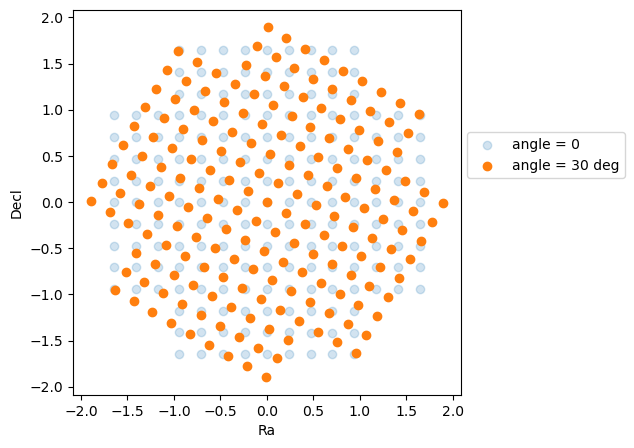

In [41]:
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(coords['Ra'], coords['Decl'], alpha=0.2, label='angle = 0')
ax.set_xlabel('Ra')
ax.set_ylabel('Decl')
ax.scatter(rot_coords['Ra'], rot_coords['Decl'], label='angle = 30 deg')
ax.legend(bbox_to_anchor=[1.,0.7])